In [1]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import FastICA
from scipy.signal import find_peaks

from scipy.signal import find_peaks, welch
from scipy.stats import pearsonr


In [2]:
# Root directory of your dataset
base_dir = './'  # Adjust if needed
output_dir = 'combined_signals'  # Save mixed signals here

os.makedirs(output_dir, exist_ok=True)

# Subdirectory and levels
subdirectory = [f"sub{str(i).zfill(2)}" for i in range(1, 11)]
levels = [f"l{i}" for i in range(1, 6)]


Step 1 - Combine fecg + mecg + noise 1 + noise 2 

In [3]:
# Iterate through subdirectory and levels
for sub in subdirectory:
    for level in levels:
        prefix = f"{sub}_snr00dB_{level}_c0"
        print(f"Processing: {prefix}")

        sub_folder = os.path.join(base_dir, sub, level)

        try:
            # Read the signals
            fecg = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_fecg1"))
            mecg = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_mecg"))
            noise1 = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_noise1"))
            noise2 = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_noise2"))

            # Extract the signals (first column of each)
            f_ecg = fecg.p_signal[:, 0]
            m_ecg = mecg.p_signal[:, 0]
            n1 = noise1.p_signal[:, 0]
            n2 = noise2.p_signal[:, 0]

            # Ensure they all have the same length
            min_len = min(len(f_ecg), len(m_ecg), len(n1), len(n2))
            f_ecg = f_ecg[:min_len]
            m_ecg = m_ecg[:min_len]
            n1 = n1[:min_len]
            n2 = n2[:min_len]

            # Stack the signals together as a multi-channel signal (4 channels)
            multi_channel_signal = np.stack([f_ecg, m_ecg, n1, n2], axis=1)  # Shape: (samples, 4)

            # Save this multi-channel signal
            record_name = f"{sub}_{level}_c0_combined"

            # Save the combined signals as a WFDB record (4 channels)
            wfdb.wrsamp(
                record_name=record_name,
                fs=fecg.fs,
                units=['mV'] * 4,  # Units for each of the 4 signals
                sig_name=['fecg', 'mecg', 'noise1', 'noise2'],
                p_signal=multi_channel_signal
            )

            # Move the generated .hea and .dat to the combined_signals directory
            os.makedirs(output_dir, exist_ok=True)
            for ext in ['hea', 'dat']:
                os.replace(
                    f"{record_name}.{ext}",
                    os.path.join(output_dir, f"{record_name}.{ext}")
                )

            print(f"Saved combined signal to {record_name}.hea / .dat")

        except Exception as e:
            print(f"Error processing {prefix}: {e}")

Processing: sub01_snr00dB_l1_c0
Saved combined signal to sub01_l1_c0_combined.hea / .dat
Processing: sub01_snr00dB_l2_c0
Saved combined signal to sub01_l2_c0_combined.hea / .dat
Processing: sub01_snr00dB_l3_c0
Saved combined signal to sub01_l3_c0_combined.hea / .dat
Processing: sub01_snr00dB_l4_c0
Saved combined signal to sub01_l4_c0_combined.hea / .dat
Processing: sub01_snr00dB_l5_c0
Saved combined signal to sub01_l5_c0_combined.hea / .dat
Processing: sub02_snr00dB_l1_c0
Saved combined signal to sub02_l1_c0_combined.hea / .dat
Processing: sub02_snr00dB_l2_c0
Saved combined signal to sub02_l2_c0_combined.hea / .dat
Processing: sub02_snr00dB_l3_c0
Saved combined signal to sub02_l3_c0_combined.hea / .dat
Processing: sub02_snr00dB_l4_c0
Saved combined signal to sub02_l4_c0_combined.hea / .dat
Processing: sub02_snr00dB_l5_c0
Saved combined signal to sub02_l5_c0_combined.hea / .dat
Processing: sub03_snr00dB_l1_c0
Saved combined signal to sub03_l1_c0_combined.hea / .dat
Processing: sub03_snr

Step 2: Plot combined signal and separated signals 

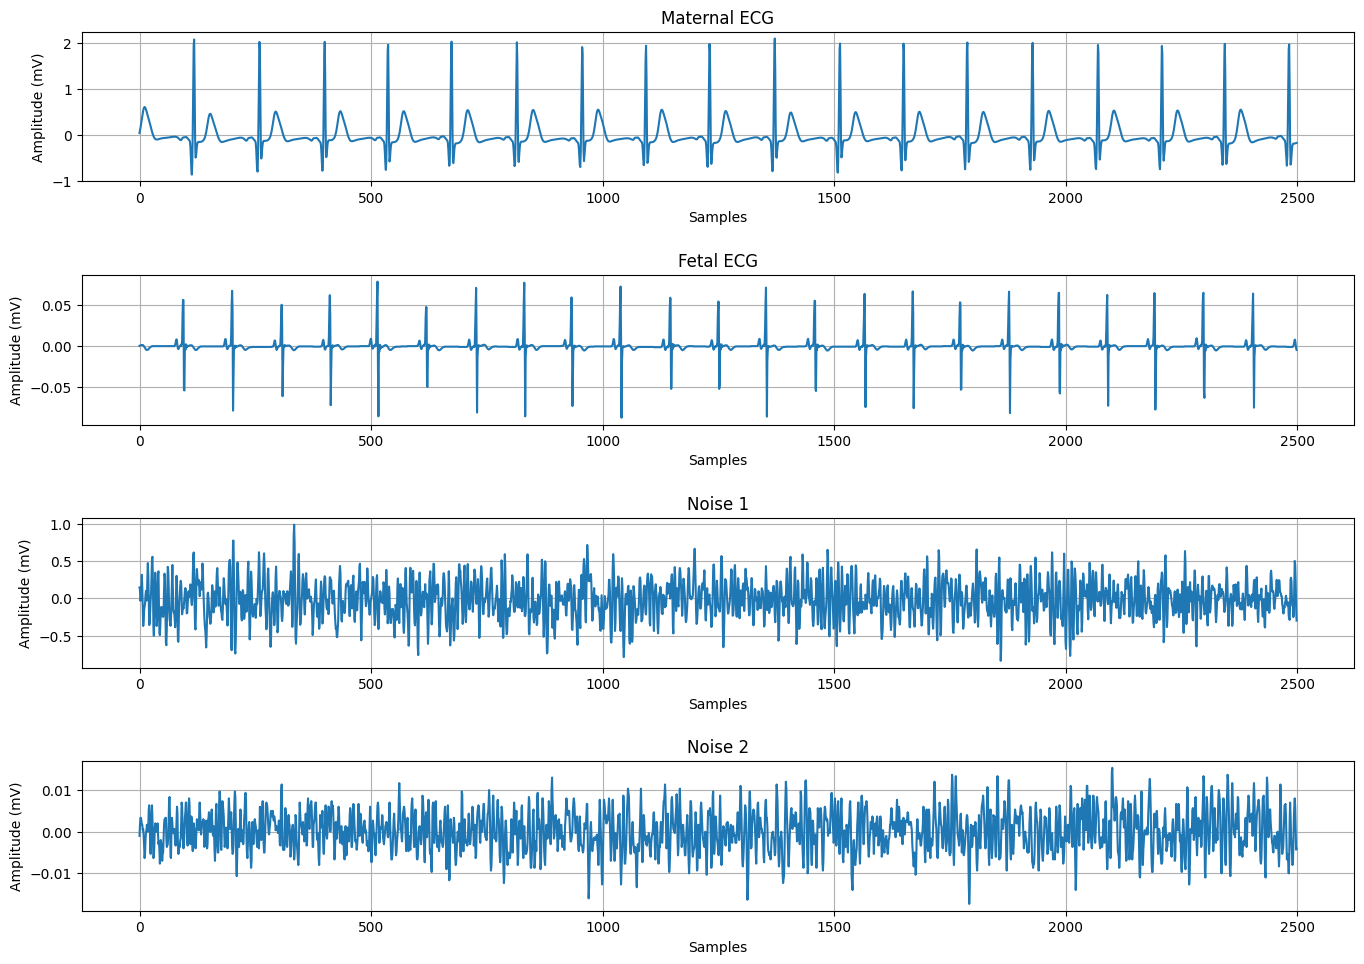

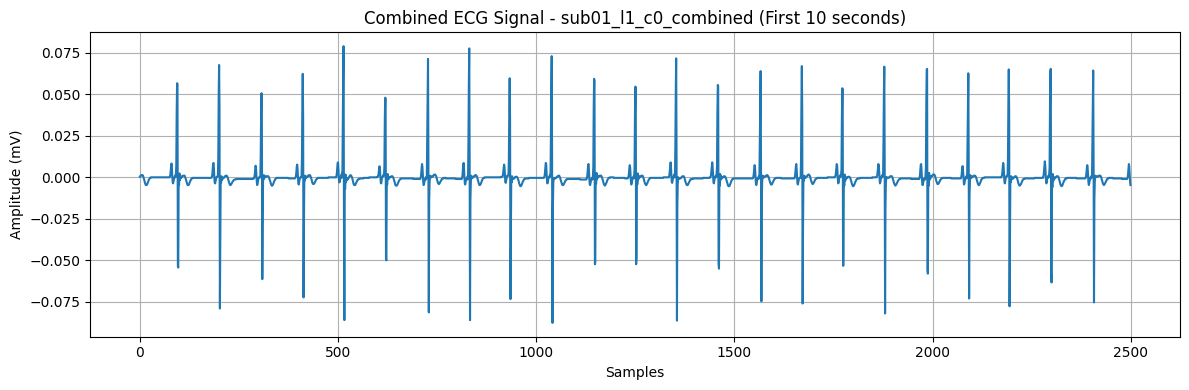

In [4]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt

# Setup
record_name = 'sub01_l1_c0_combined'  # Change as needed
record_path = os.path.join('combined_signals', record_name)

# Load combined signal
record = wfdb.rdrecord(record_path)
combined_signal = record.p_signal[:, 0]
fs = record.fs
seconds = 10
samples_to_plot = int(seconds * fs)

# Load original individual signals (same base name, but from original folders)
subject = "sub01"
level = "l1"
base_dir = "./"
prefix = f"{subject}_snr00dB_{level}_c0"
sub_folder = os.path.join(base_dir, subject, level)

# Read components
fetal = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_fecg1"))
maternal = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_mecg"))
noise1 = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_noise1"))
noise2 = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_noise2"))

# Extract and trim
f_ecg = fetal.p_signal[:, 0][:samples_to_plot]
m_ecg = maternal.p_signal[:, 0][:samples_to_plot]
n1 = noise1.p_signal[:, 0][:samples_to_plot]
n2 = noise2.p_signal[:, 0][:samples_to_plot]
combined_signal = combined_signal[:samples_to_plot]

# Plot components + combined
labels = ['Maternal ECG', 'Fetal ECG', 'Noise 1', 'Noise 2']
signals = [m_ecg, f_ecg, n1, n2]

plt.figure(figsize=(14, 12))
for i, sig in enumerate(signals):
    plt.subplot(5, 1, i+1)
    plt.plot(sig)
    plt.title(labels[i])
    plt.xlabel("Samples")
    plt.ylabel("Amplitude (mV)")
    plt.grid()


plt.tight_layout(pad=2)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(combined_signal[:int(fs*seconds)])
plt.title(f"Combined ECG Signal - {record_name} (First {seconds} seconds)")
plt.xlabel("Samples")
plt.ylabel("Amplitude (mV)")
plt.grid()
plt.tight_layout()
plt.show()


Step 3: Load the combined signal (4 channels signal) and apply FastICA for Blind Source Separation

In [5]:
# Path for combined signals and ICA output
combined_dir = 'combined_signals'
ica_output_dir = 'ica_outputs'
os.makedirs(ica_output_dir, exist_ok=True)

subdirectory = [f"sub{str(i).zfill(2)}" for i in range(1, 11)]
levels = [f"l{i}" for i in range(1, 6)]

for sub in subdirectory:
    for level in levels:
        record_name = f"{sub}_{level}_c0_combined"
        print(f"🔍 ICA on: {record_name}")
        try:
            # Load combined signals
            record = wfdb.rdrecord(os.path.join(combined_dir, record_name))
            mixed = record.p_signal

            # Apply ICA
            ica = FastICA(n_components=4, random_state=0)
            separated = ica.fit_transform(mixed)

            # Save output (as NumPy array)
            np.save(os.path.join(ica_output_dir, f"{record_name}_ica.npy"), separated)

        except Exception as e:
            print(f"Error: {e}")

🔍 ICA on: sub01_l1_c0_combined
🔍 ICA on: sub01_l2_c0_combined
🔍 ICA on: sub01_l3_c0_combined
🔍 ICA on: sub01_l4_c0_combined
🔍 ICA on: sub01_l5_c0_combined
🔍 ICA on: sub02_l1_c0_combined
🔍 ICA on: sub02_l2_c0_combined
🔍 ICA on: sub02_l3_c0_combined
🔍 ICA on: sub02_l4_c0_combined
🔍 ICA on: sub02_l5_c0_combined
🔍 ICA on: sub03_l1_c0_combined
🔍 ICA on: sub03_l2_c0_combined
🔍 ICA on: sub03_l3_c0_combined
🔍 ICA on: sub03_l4_c0_combined
🔍 ICA on: sub03_l5_c0_combined
🔍 ICA on: sub04_l1_c0_combined
🔍 ICA on: sub04_l2_c0_combined
🔍 ICA on: sub04_l3_c0_combined
🔍 ICA on: sub04_l4_c0_combined
🔍 ICA on: sub04_l5_c0_combined
🔍 ICA on: sub05_l1_c0_combined
🔍 ICA on: sub05_l2_c0_combined
🔍 ICA on: sub05_l3_c0_combined
🔍 ICA on: sub05_l4_c0_combined
🔍 ICA on: sub05_l5_c0_combined
🔍 ICA on: sub06_l1_c0_combined
🔍 ICA on: sub06_l2_c0_combined
🔍 ICA on: sub06_l3_c0_combined
🔍 ICA on: sub06_l4_c0_combined
🔍 ICA on: sub06_l5_c0_combined
🔍 ICA on: sub07_l1_c0_combined
🔍 ICA on: sub07_l2_c0_combined
🔍 ICA on

Step 4: Evaluation of Separation for all 50 signals 
- Heart rate estimation and comparation against ground truth .qrs annotations
- Correlation with ground truth signals

In [6]:
base_dir = './'
combined_dir = 'combined_signals'
ica_output_dir = 'ica_outputs'
results_dir = 'ica_analysis_results'
cleaned_dir = 'ica_cleaned_signals'
os.makedirs(results_dir, exist_ok=True)
os.makedirs(cleaned_dir, exist_ok=True)

subdirectory = [f"sub{str(i).zfill(2)}" for i in range(1, 11)]
levels = [f"l{i}" for i in range(1, 6)]

def compute_hr(peaks, fs):
    rr_intervals = np.diff(peaks) / fs
    return 60 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0

for sub in subdirectory:
    for level in levels:
        record_base = f"{sub}_snr00dB_{level}_c0"
        combined_record = f"{sub}_{level}_c0_combined"
        print(f"Analyzing: {combined_record}")

        try:
            # Load ICA components
            ica_path = os.path.join(ica_output_dir, f"{combined_record}_ica.npy")
            separated = np.load(ica_path)

            # Load the sampling frequency
            combined_rec = wfdb.rdrecord(os.path.join(combined_dir, combined_record))
            fs = combined_rec.fs

            # Load original signals (ground truth for comparison)
            sub_folder = os.path.join(base_dir, sub, level)
            fetal = wfdb.rdrecord(os.path.join(sub_folder, f"{record_base}_fecg1"))
            maternal = wfdb.rdrecord(os.path.join(sub_folder, f"{record_base}_mecg"))
            f_ecg = fetal.p_signal[:, 0]
            m_ecg = maternal.p_signal[:, 0]
            min_len = min(len(f_ecg), len(separated))
            f_ecg = f_ecg[:min_len]
            m_ecg = m_ecg[:min_len]
            separated = separated[:min_len]

            # Load QRS annotations
            fecg_ann = wfdb.rdann(os.path.join(sub_folder, f"{record_base}_fecg1"), 'qrs')
            mecg_ann = wfdb.rdann(os.path.join(sub_folder, f"{record_base}_mecg"), 'qrs')
            fecg_rpeaks = fecg_ann.sample
            mecg_rpeaks = mecg_ann.sample

            # Compute ground truth HR
            true_fecg_hr = compute_hr(fecg_rpeaks, fs)
            true_mecg_hr = compute_hr(mecg_rpeaks, fs)

            # Prepare output file
            result_file = os.path.join(results_dir, f"{combined_record}_analysis.txt")
            with open(result_file, 'w') as f:
                f.write(f"=== Analysis: {combined_record} ===\n")
                f.write(f"Sampling Frequency: {fs} Hz\n")
                f.write(f"True Fetal HR:    {true_fecg_hr:.1f} bpm\n")
                f.write(f"True Maternal HR: {true_mecg_hr:.1f} bpm\n\n")

                correlations_f = []
                correlations_m = []

                for i in range(4):
                    signal = separated[:, i]
                    peaks, _ = find_peaks(signal, distance=fs*0.4)
                    hr = compute_hr(peaks, fs)

                    corr_f, _ = pearsonr(signal, f_ecg)
                    corr_m, _ = pearsonr(signal, m_ecg)

                    correlations_f.append((corr_f, i))
                    correlations_m.append((corr_m, i))

                    f.write(f"--- Component {i+1} ---\n")
                    f.write(f"Estimated HR: {hr:.1f} bpm\n")
                    f.write(f"Correlation with Fetal ECG:    r = {corr_f:.3f}\n")
                    f.write(f"Correlation with Maternal ECG: r = {corr_m:.3f}\n\n")

                # Select best components (max correlation)
                best_fetal_idx = max(correlations_f, key=lambda x: abs(x[0]))[1]
                best_maternal_idx = max(correlations_m, key=lambda x: abs(x[0]))[1]

                f.write(f"Selected Fetal Component:    {best_fetal_idx + 1}\n")
                f.write(f"Selected Maternal Component: {best_maternal_idx + 1}\n")

            # Save cleaned signals
            cleaned_fecg = separated[:, best_fetal_idx]
            cleaned_mecg = separated[:, best_maternal_idx]

            np.save(os.path.join(cleaned_dir, f"{combined_record}_cleaned_fecg.npy"), cleaned_fecg)
            np.save(os.path.join(cleaned_dir, f"{combined_record}_cleaned_mecg.npy"), cleaned_mecg)

            print(f"Saved: {result_file}")
            print(f"Saved cleaned fetal and maternal ECG for {combined_record}")

        except Exception as e:
            print(f"Error processing {combined_record}: {e}")

Analyzing: sub01_l1_c0_combined
Saved: ica_analysis_results/sub01_l1_c0_combined_analysis.txt
Saved cleaned fetal and maternal ECG for sub01_l1_c0_combined
Analyzing: sub01_l2_c0_combined
Saved: ica_analysis_results/sub01_l2_c0_combined_analysis.txt
Saved cleaned fetal and maternal ECG for sub01_l2_c0_combined
Analyzing: sub01_l3_c0_combined
Saved: ica_analysis_results/sub01_l3_c0_combined_analysis.txt
Saved cleaned fetal and maternal ECG for sub01_l3_c0_combined
Analyzing: sub01_l4_c0_combined
Saved: ica_analysis_results/sub01_l4_c0_combined_analysis.txt
Saved cleaned fetal and maternal ECG for sub01_l4_c0_combined
Analyzing: sub01_l5_c0_combined
Saved: ica_analysis_results/sub01_l5_c0_combined_analysis.txt
Saved cleaned fetal and maternal ECG for sub01_l5_c0_combined
Analyzing: sub02_l1_c0_combined
Saved: ica_analysis_results/sub02_l1_c0_combined_analysis.txt
Saved cleaned fetal and maternal ECG for sub02_l1_c0_combined
Analyzing: sub02_l2_c0_combined
Saved: ica_analysis_results/sub0

Just an example of what is done in step 3 and 4 on signals from Sub01 and L1 


--- Ground Truth Heart Rates ---
Fetal HR:    143.0 bpm
Maternal HR: 107.8 bpm

--- ICA Component HR Estimation ---
Component 1: HR ≈ 107.8 bpm
Component 2: HR ≈ 112.6 bpm
Component 3: HR ≈ 111.7 bpm
Component 4: HR ≈ 142.2 bpm

--- Correlation with Ground Truth Signals ---

Component 1:
  Correlation with Maternal ECG: r = 1.000
  Correlation with Fetal ECG: r = -0.001

Component 2:
  Correlation with Maternal ECG: r = 0.001
  Correlation with Fetal ECG: r = -0.001

Component 3:
  Correlation with Maternal ECG: r = 0.001
  Correlation with Fetal ECG: r = 0.000

Component 4:
  Correlation with Maternal ECG: r = 0.001
  Correlation with Fetal ECG: r = -1.000


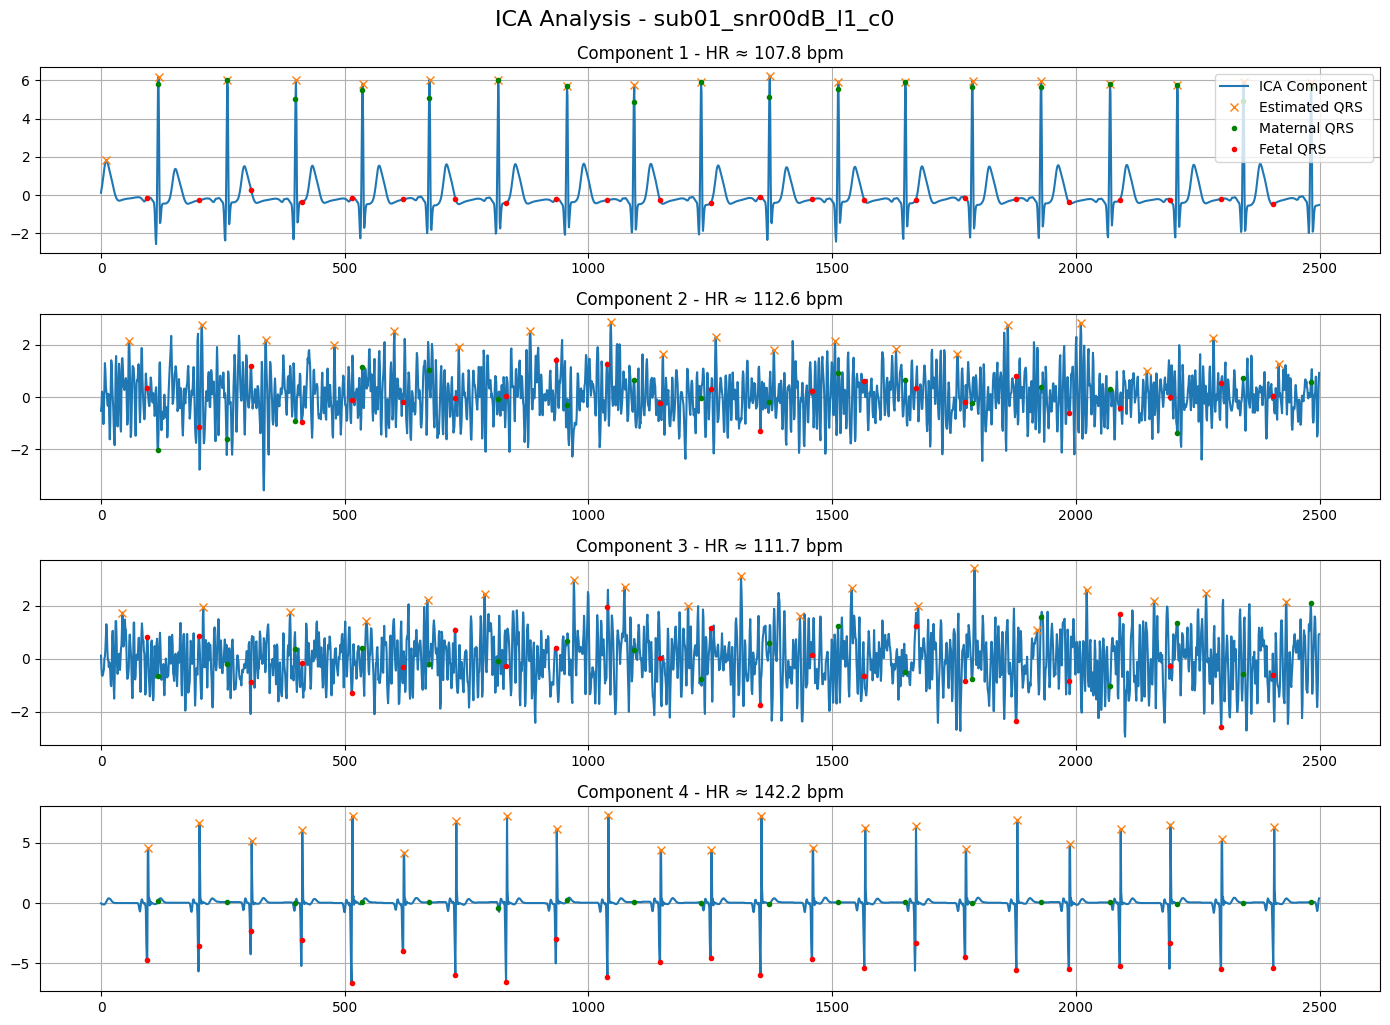

In [7]:
subject = 'sub01'
level = 'l1'
record_base = f"{subject}_snr00dB_{level}_c0"
combined_record = f"{subject}_{level}_c0_combined"
record_path = os.path.join('combined_signals', combined_record)
ica_path = os.path.join('ica_outputs', f"{combined_record}_ica.npy")

# Load combined record and ICA components
record = wfdb.rdrecord(record_path)
fs = record.fs
separated_signals = np.load(ica_path)

# Load original signals to compute correlation
sub_folder = os.path.join('./', subject, level)
fetal = wfdb.rdrecord(os.path.join(sub_folder, f"{record_base}_fecg1"))
maternal = wfdb.rdrecord(os.path.join(sub_folder, f"{record_base}_mecg"))
f_ecg = fetal.p_signal[:, 0]
m_ecg = maternal.p_signal[:, 0]

# Load ground truth QRS annotations
fecg_ann = wfdb.rdann(os.path.join(sub_folder, f"{record_base}_fecg1"), 'qrs')
mecg_ann = wfdb.rdann(os.path.join(sub_folder, f"{record_base}_mecg"), 'qrs')
fecg_rpeaks = fecg_ann.sample
mecg_rpeaks = mecg_ann.sample

# Ground truth HR
true_fecg_hr = compute_hr(fecg_rpeaks, fs)
true_mecg_hr = compute_hr(mecg_rpeaks, fs)
print("\n--- Ground Truth Heart Rates ---")
print(f"Fetal HR:    {true_fecg_hr:.1f} bpm")
print(f"Maternal HR: {true_mecg_hr:.1f} bpm")

# ICA HR Estimation
estimated_peaks = []
estimated_hrs = []

print("\n--- ICA Component HR Estimation ---")
for i in range(4):
    sig = separated_signals[:, i]
    peaks, _ = find_peaks(sig, distance=int(0.4 * fs))  # ~150 bpm
    hr = compute_hr(peaks, fs)
    estimated_peaks.append(peaks)
    estimated_hrs.append(hr)
    print(f"Component {i+1}: HR ≈ {hr:.1f} bpm")

# Correlation with ground truth waveforms
print("\n--- Correlation with Ground Truth Signals ---")
for i in range(4):
    print(f"\nComponent {i+1}:")
    for label, original in zip(['Maternal', 'Fetal'], [m_ecg, f_ecg]):
        r, _ = pearsonr(separated_signals[:len(original), i], original)
        print(f"  Correlation with {label} ECG: r = {r:.3f}")

# Plot first 10 seconds
samples_to_plot = fs * 10
plt.figure(figsize=(14, 10))
for i in range(4):
    plt.subplot(4, 1, i+1)
    sig = separated_signals[:samples_to_plot, i]
    plt.plot(sig, label='ICA Component')
    # Estimated peaks
    peaks = estimated_peaks[i]
    peaks = peaks[peaks < samples_to_plot]
    plt.plot(peaks, sig[peaks], 'x', label='Estimated QRS')
    # Ground truth
    gt_m = mecg_rpeaks[mecg_rpeaks < samples_to_plot]
    gt_f = fecg_rpeaks[fecg_rpeaks < samples_to_plot]
    plt.plot(gt_m, sig[gt_m], 'go', markersize=3, label='Maternal QRS')
    plt.plot(gt_f, sig[gt_f], 'ro', markersize=3, label='Fetal QRS')
    plt.title(f"Component {i+1} - HR ≈ {estimated_hrs[i]:.1f} bpm")
    if i == 0:
        plt.legend(loc='upper right')
    plt.grid()

plt.tight_layout()
plt.suptitle(f"ICA Analysis - {record_base}", fontsize=16, y=1.02)
plt.show()